# LP Algorithm development v1.0

In [2]:
# import watermark
%reload_ext watermark
%watermark

Last updated: 2024-03-08T10:58:47.580227+01:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.22.2

Compiler    : MSC v.1935 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import shapely
from shapely.geometry import Point
from shapely.ops import nearest_points
from pyproj import Transformer
import geopandas as gpd
import osmnx as ox
# import networkx as nx
import pandana as pdna
import pulp

pd.set_option('display.float_format', lambda x: '%.3f' % x)
%watermark -w
%watermark -iv

Watermark: 2.4.3

pandana   : 0.7
shapely   : 2.0.3
geopandas : 0.14.3
matplotlib: 3.8.3
pandas    : 2.2.1
pulp      : 2.8.0
osmnx     : 1.9.1
numpy     : 1.26.4



## 1. Load the data
### 1.1 Loading a small road network of Grünerløkka for testing.
For all input data we change the CRS from WGS84 to UTM33N. This is done to make the distance calculations easier.  
Also trying to use pygeos instead of shapely for faster geometry operations. However, pygeos is not entirely integrated with geopandas yet, so we need to convert geometries back to shapely geometries for inserting them into geopandas dataframes.

In [4]:
### Road network file of Grünerløkka, Oslo

# load the graph from file
# gruner_graph99 = ox.io.load_graphml("GrunerGraphTravelTime.graphml")

# 1) Read from local path
gruner_filepath = "../data/GrunerServiceImputed.graphml" # GraphML format (with speed and travel time)
gruner_graph = ox.load_graphml(gruner_filepath) # originally in WGS84 (EPSG:4326)

# 2) Fetch from OSM - using OSMnx 
# gruner_graph = ox.graph_from_place('Grünerløkka, Oslo, Norway', network_type="drive_service") # originally in WGS84 (EPSG:4326)

In [5]:
gruner_graph = ox.projection.project_graph(gruner_graph, to_crs='EPSG:32633') # project to UTM zone 33N
print(f"Type of gruner_graph: {type(gruner_graph)}")
print(f"CRS of gruner_graph:  {gruner_graph.graph['crs']}")

# plot graph
# fig, ax = ox.plot_graph(gruner_graph, node_size=4, edge_linewidth=0.5, edge_color="w")

Type of gruner_graph: <class 'networkx.classes.multidigraph.MultiDiGraph'>
CRS of gruner_graph:  EPSG:32633


Convert graph to GeoDataFrame and plot it.   
`osmnx.utils_graph.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)` - Convert a MultiDiGraph to node and/or edge GeoDataFrames.

In [6]:
# converting the graph network to node and edge GeoPandas GeoDataFrames
nodes, edges = ox.graph_to_gdfs(gruner_graph, nodes=True, edges=True)
print(f"type of nodes:{type(nodes)}")
# nodes.head()
edges.head() # verify edges contain speed and travel time

type of nodes:<class 'geopandas.geodataframe.GeoDataFrame'>


osmid lanes           name  \
u          v          key                                                
79448      3165357950 0                 129061337     2  Maridalsveien   
3165357950 79448      0                 129061337     2  Maridalsveien   
79465      106183     0                   4211442     2    Toftes gate   
           12630987   0                 349267814     2    Toftes gate   
           79475      0    [882463938, 337073150]     3     Sannergata   

                             highway  oneway reversed  length  \
u          v          key                                       
79448      3165357950 0    secondary   False    False 107.935   
3165357950 79448      0    secondary   False     True 107.935   
79465      106183     0    secondary   False     True 139.757   
           12630987   0    secondary   False    False  99.113   
           79475      0     tertiary   False     True 111.025   

                                                                    geometry  \
u          v          key                                                      
79448      3165357950 0    LINESTRING (262538.332 6650300.213, 262536.391...   
3165357950 79448      0    LINESTRING (262538.592 6650406.186, 262532.197...   
79465      106183     0    LINESTRING (263161.645 6651034.904, 263161.276...   
           12630987   0    LINESTRING (263161.645 6651034.904, 263162.006...   
           79475      0    LINESTRING (263161.645 6651034.904, 263160.078...   

                           speed_kph  travel_time maxspeed  ref junction  \
u          v          key                                                  
79448      3165357950 0       44.500        8.700      NaN  NaN      NaN   
3165357950 79448      0       44.500        8.700      NaN  NaN      NaN   
79465      106183     0       44.500       11.300      NaN  NaN      NaN   
           12630987   0       40.000        8.900       40  NaN      NaN   
           79475      0       40.000       10.000       40  NaN      NaN   

                          width service bridge tunnel access  
u          v          key                                     
79448      3165357950 0     NaN     NaN    NaN    NaN    NaN  
3165357950 79448      0     NaN     NaN    NaN    NaN    NaN  
79465      106183     0     NaN     NaN    NaN    NaN    NaN  
           12630987   0     NaN     NaN    NaN    NaN    NaN  
           79475      0     NaN     NaN    NaN    NaN    NaN

## 2. Load population data
Loading population data in 250x250m grid cells for Oslo, Norway.   
Format: GeoJSON  
Original CRS: WGS84 (EPSG:4326). Convert to UTM33N (EPSG:32633).

Grünerløkka population statistics:
 count    100.000
mean     836.890
std      565.712
min        1.000
25%      349.250
50%      791.000
75%     1278.250
max     1989.000
Name: population, dtype: float64
<class 'geopandas.geodataframe.GeoDataFrame'>


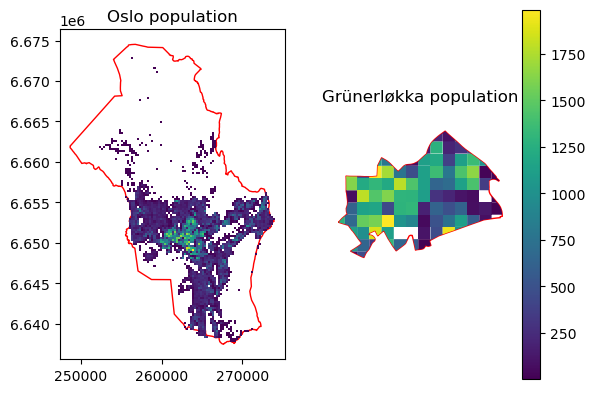

In [7]:
# load geopandas dataframe of population data
oslo_population_geojson = "..data\oslo_population_dataset\Oslo_pop2023_250m_wgs84_epsg4326_geojson\oslo_pop2023_250m_wgs84_epsg4326.geojson"

oslo_population = gpd.read_file(oslo_population_geojson)
oslo_population.to_crs(crs='EPSG:32633', inplace=True) # convert from WGS84 (EPSG:4326) to UTM zone 33N (EPSG:32633)
oslo_population.columns = ['id', 'population', 'geometry'] # rename column names

# Clip the population data using the Grünerløkka footprint from OSM
oslo_footprint_osm = ox.geocode_to_gdf("Oslo, Norway")
gruner_footprint_osm = ox.geocode_to_gdf("Grünerløkka, Norway")
gruner_footprint_osm = gruner_footprint_osm.to_crs(epsg=32633) # convert from WGS84 (EPSG:4326) to UTM zone 33N (EPSG:32633)
oslo_footprint_osm = oslo_footprint_osm.to_crs(epsg=32633) # convert from WGS84 (EPSG:4326) to UTM zone 33N (EPSG:32633)
gruner_population = gpd.clip(oslo_population, gruner_footprint_osm)

# print statistics of population data
print("Grünerløkka population statistics:\n", gruner_population['population'].describe())
print(type(gruner_population))
gruner_population.head()

# Visualize population data of Oslo and Grünerløkka
fig, axs = plt.subplots(1, 2)
oslo_footprint_osm.plot(ax=axs[0], facecolor="none", edgecolor="r")   # Oslo footprint
gruner_footprint_osm.plot(ax=axs[1], facecolor="none", edgecolor="r") # Grünerløkka footprint
oslo_population.plot(column='population', cmap='viridis', ax=axs[0])  # Oslo population
gruner_population.plot(column='population', cmap='viridis', legend=True, ax=axs[1]) # Grünerløkka population
axs[0].set_title('Oslo population')
axs[1].set_title('Grünerløkka population')
axs[1].axis('off'); plt.show()

After inspection, we see the population ranges from 1 to 1989 in the 250x250m grid cells, in Grünerløkka.

## 3 Event points
### 3.1 Simulate events
Task: simulate events the police cars have to respond to based on the population data (250x250m gridcells).  
For each gridcell, simulated events are generated as follows:
$$ X_i = a * population_i + b * randomfactor $$

where $X_i$ is the number of simulated events generated in gridcell i, $population_i$ is the population in gridcell i, and $randomfactor$ is a normally distributed random variable ($N(0,1)$), with mean 0 and standard deviation 1 . a and b are scaling constants to adjust the number of simulated events.

In [8]:
# Define scaling constants
population_multiplier = 0.001 # increase points at high population areas
randomness_multiplier = 0.3   # increase randomness to spread the points more

# Normal distribution parameters
mu = 0  # mean
sigma = 1  # standard deviation

# Function to generate random points (events) within a polygon (gridcell)
def generate_random_points(poly, num_points):
    points = []
    min_x, min_y, max_x, max_y = poly.bounds
    while len(points) < num_points:
        random_point = Point(np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y)) # uniform distribution in each gridcell
        if random_point.within(poly):
            points.append(random_point)
    return points

In [9]:
# Simulate points based on population and generate them within each grid cell
simulated_event_points = []
for _, row in gruner_population.iterrows():
    num_points = np.round(population_multiplier * row['population'] + randomness_multiplier * np.random.normal(mu, sigma))
    num_points = max(int(num_points), 0)  # Ensure non-negative integer
    if num_points > 0:
        simulated_event_points += generate_random_points(row['geometry'], num_points)

# print number of points and add to GeoDataFrame
print(f"Number of simulated event points: {len(simulated_event_points)} (OBS: will vary due to randomness in the simulation process.)")

# Create GeoDataFrame of the simulated event points
event_points_gdf = gpd.GeoDataFrame(geometry=simulated_event_points, crs=gruner_population.crs)
event_points_gdf.head(3)

Number of simulated event points: 83 (OBS: will vary due to randomness in the simulation process.)


,geometry
0,POINT (264263.145 6649736.210)
1,POINT (264456.073 6649858.390)
2,POINT (264569.903 6649963.934)


In [10]:
# JUST INSPECTION: Run a loop to simulate lots of points and inspect the distribution over the area
TEST_num_simulations = 500
TEST_simulated_event_points = []
for _ in range(TEST_num_simulations):
    for _, row in gruner_population.iterrows():
        num_points = np.round(population_multiplier * row['population'] + randomness_multiplier * np.random.normal(mu, sigma))
        num_points = max(int(num_points), 0)  # Ensure non-negative integer
        if num_points > 0:
            TEST_simulated_event_points += generate_random_points(row['geometry'], num_points)

# print number of points and add to GeoDataFrame
print(f"Nr of simulations: {TEST_num_simulations} | Nr of simulated (test) event points: {len(TEST_simulated_event_points)} (OBS: will vary due to randomness in the simulation process.)")

# Create GeoDataFrame of the simulated event points
TEST_event_points_gdf = gpd.GeoDataFrame(geometry=TEST_simulated_event_points, crs=gruner_population.crs)

# event_points_gdf = TEST_event_points_gdf  # ############ TESTING PROCESSING OF MANY POINTS ##################### #
event_points_gdf.head(3)

Nr of simulations: 500 | Nr of simulated (test) event points: 41710 (OBS: will vary due to randomness in the simulation process.)


,geometry
0,POINT (264263.145 6649736.210)
1,POINT (264456.073 6649858.390)
2,POINT (264569.903 6649963.934)


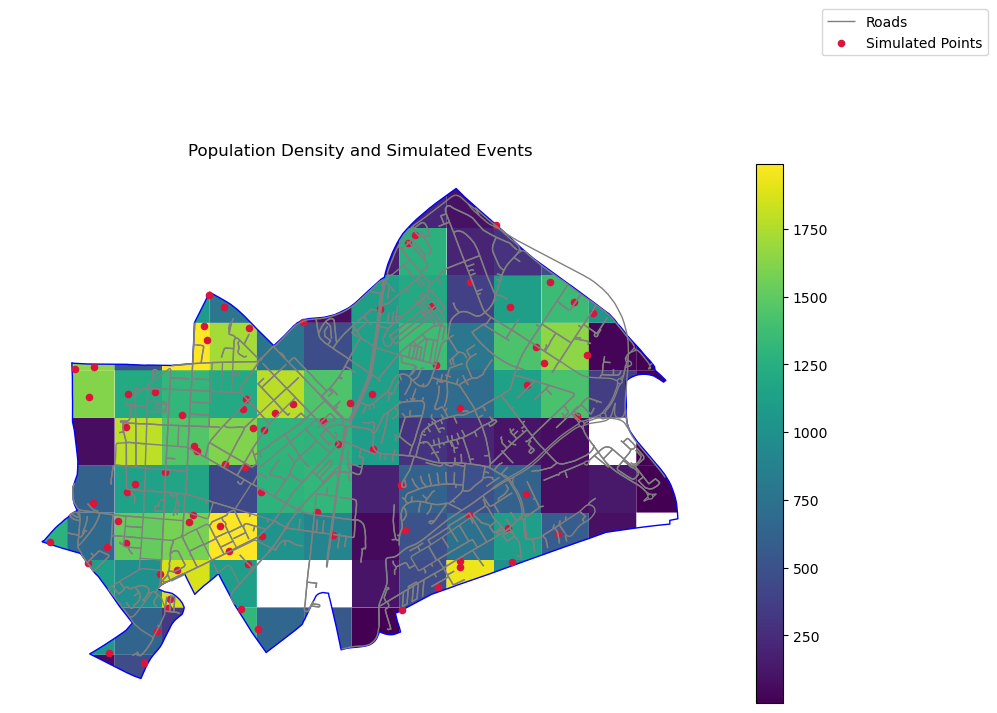

In [11]:
# JUST INSPECTION:  Plot the road network
fig, ax = plt.subplots(figsize=(12, 7)) # x,y (width, height)
edges.plot(ax=ax, linewidth=1, edgecolor='gray', label='Roads') # Road network
gruner_population.plot(ax=ax, column='population', cmap='viridis', legend=True)
gruner_footprint_osm.plot(ax=ax, facecolor="none", edgecolor="b") # Grünerløkka footprint
event_points_gdf.plot(ax=ax, color='crimson', markersize=20, label='Simulated Points') # Simulated points
ax.set_title('Population Density and Simulated Events'); 
plt.legend(loc="upper left", bbox_to_anchor=(1.15, 1.3)); 
ax.axis('off'); plt.show()

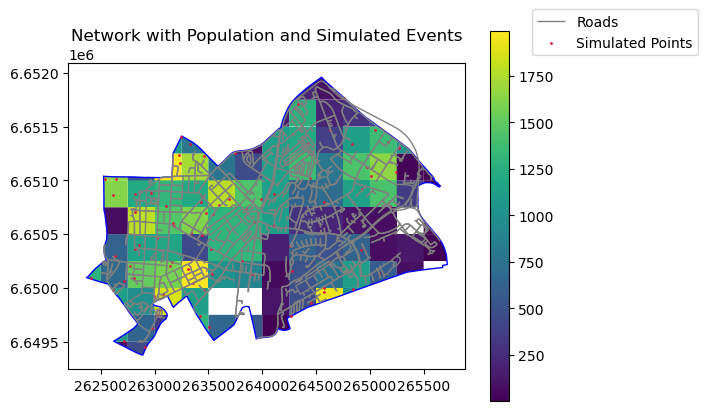

In [12]:
# Plot the road network
fig, ax = plt.subplots()
edges.plot(ax=ax, linewidth=1, edgecolor='gray', label='Roads') # Road network
gruner_population.plot(ax=ax, column='population', cmap='viridis', legend=True)
gruner_footprint_osm.plot(ax=ax, facecolor="none", edgecolor="b") # Grünerløkka footprint
event_points_gdf.plot(ax=ax, color='crimson', markersize=1, label='Simulated Points') # Simulated points   ##### TESTING MANY POINTS SPEED ####
ax.set_title('Network with Population and Simulated Events'); 
plt.legend(loc="upper left", bbox_to_anchor=(1.15, 1.2)); plt.show()

## 3.2 Add weight to each event point
Weight is added to each demand node (event) based on the distance to one manually defined crime hotspot (left edge in this case).  
The weight is assigned in intervals based on the distance to the crime hotspot. Shorter distance to the hotspot gives higher weight.
- [0m  , 250m] - weight = 5
- [250m, 600m] - weight = 3
- [600m, inf ] - weight = 1

In [13]:
# Using Transformer for coordinate conversion
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32633", always_xy=True) # from WGS84 to UTM 33N
crime_hotspot_wgs84 = (59.9211733, 10.7531202) # crime hotspot location in WGS84 coordinates (latitude, longitude)
x, y = transformer.transform(crime_hotspot_wgs84[1], crime_hotspot_wgs84[0])
crime_hotspot_location_utm = Point(x, y) # crime hotspot location in UTM 33N coordinates

# Add hotspot to a geoDataFrame
crime_hotspot_gdf = gpd.GeoDataFrame(geometry=[crime_hotspot_location_utm], crs="EPSG:32633")
crime_hotspot_gdf.head()

,geometry
0,POINT (262663.848 6650249.174)


In [14]:
# Define distance intervals and corresponding weights
distance_intervals = [0, 250, 600]  # Example intervals in kilometers
weights = [5, 3, 1]  # Corresponding weights

# Function to categorize distance and assign weight
def assign_weight(point, crime_hotspot_gdf, intervals, weights):
    # Compute distances to all hotspots and find the minimum
    distances = crime_hotspot_gdf.distance(point)
    min_distance = distances.min()
    
    # Categorize the minimum distance into predefined intervals
    weight_category = np.digitize([min_distance], bins=intervals, right=True)[0]
    
    # Assign the corresponding weight based on categorized distance
    # Note: np.digitize bins start counting from 1, hence weight_category - 1 to match list index
    weight = weights[weight_category - 1] if weight_category <= len(weights) else weights[-1]
    return weight

# Vectorized application of the weight assignment function
event_points_gdf['weight'] = event_points_gdf['geometry'].apply(assign_weight, crime_hotspot_gdf=crime_hotspot_gdf, intervals=distance_intervals, weights=weights)

# Print statistics of the weights
print("\nWeight statistics:\n", event_points_gdf['weight'].describe())
print("\nWeight frequency distribution:\n", event_points_gdf['weight'].value_counts())
event_points_gdf.head(3)


Weight statistics:
 count   83.000
mean     1.506
std      1.162
min      1.000
25%      1.000
50%      1.000
75%      1.000
max      5.000
Name: weight, dtype: float64

Weight frequency distribution:
 weight
1    68
3     9
5     6
Name: count, dtype: int64


,geometry,weight
0,POINT (264263.145 6649736.210),1
1,POINT (264456.073 6649858.390),1
2,POINT (264569.903 6649963.934),1


## 4. Police car candidate locations
10 candidate locations for police cars are given are picked manually from OpenStreetMap.

In [15]:
# Police car locations - manually picked from OpenStreetMap (in WGS84 coordinates)
car_locations = [
    (10.7612002, 59.9223233),
    (10.7611394, 59.9254773),
    (10.7666671, 59.9199786),
    (10.7765093, 59.9260426),
    (10.7780040, 59.9285290),
    (10.7885055, 59.9317113),
    (10.7935162, 59.9261466),
    (10.7892110, 59.9244527),
    (10.7835711, 59.9206872),
    (10.7828007, 59.9247590) ]

car_locations_utm = []
# Create a Point object for each transformed location and add to the list
for location in car_locations:
    x, y = transformer.transform(location[0], location[1])
    car_locations_utm.append(Point(x, y))

# Convert locations to a GeoDataFrame
police_car_gdf = gpd.GeoDataFrame({'geometry': [Point(xy) for xy in car_locations_utm]}, crs="EPSG:32633")
police_car_gdf.head(3)

,geometry
0,POINT (263123.189 6650348.109)
1,POINT (263142.292 6650699.097)
2,POINT (263411.715 6650067.780)


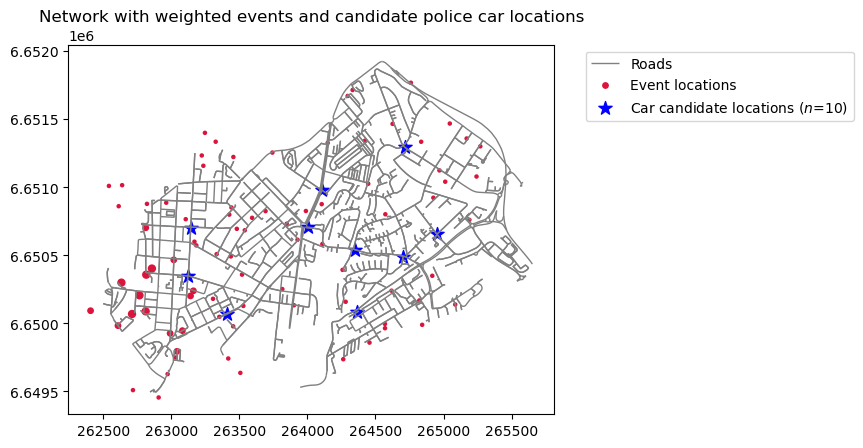

In [16]:
# Plot the road network
fig, ax = plt.subplots()
edges.plot(ax=ax, linewidth=1, edgecolor='gray', label='Roads') # Road network
event_points_gdf.plot(ax=ax, color='crimson', markersize=event_points_gdf['weight']*5, label='Event locations')
police_car_gdf.plot(ax=ax, color='blue', marker='*', markersize=100, label=f'Car candidate locations ($n$={len(car_locations)})')
ax.set_title('Network with weighted events and candidate police car locations')
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1)); plt.show()

Allright, most ingredients are in place.  
Now, we need to calculate the travel time from each police car candidate location to each event location.   
We will use the Pandana library to perform this calculation.   
Pandana is a powerful library for network analysis and can be used to calculate travel times between points on a network.   
It uses a graph-based approach to calculate the shortest path between two points on a network.   
he travel time is calculated based on the edge weights of the network, which in our case is the travel time on each road segment.

In [17]:
# Print geodataframe of the road network
edges.head(3)

,,,osmid,lanes,name,highway,oneway,reversed,length,geometry,speed_kph,travel_time,maxspeed,ref,junction,width,service,bridge,tunnel,access
u,v,key,,,,,,,,,,,,,,,,,,
79448,3165357950,0,129061337,2,Maridalsveien,secondary,False,False,107.935,"LINESTRING (262538.332 6650300.213, 262536.391...",44.500,8.700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3165357950,79448,0,129061337,2,Maridalsveien,secondary,False,True,107.935,"LINESTRING (262538.592 6650406.186, 262532.197...",44.500,8.700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79465,106183,0,4211442,2,Toftes gate,secondary,False,True,139.757,"LINESTRING (263161.645 6651034.904, 263161.276...",44.500,11.300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
nodes.head(3)

,y,x,street_count,lon,lat,highway,ref,geometry
osmid,,,,,,,,
79448,6650300.213,262538.332,3,10.751,59.922,NaN,NaN,POINT (262538.332 6650300.213)
3165357950,6650406.186,262538.592,3,10.751,59.923,NaN,NaN,POINT (262538.592 6650406.186)
79465,6651034.904,263161.645,4,10.761,59.928,traffic_signals,NaN,POINT (263161.645 6651034.904)


## 5. Pandana network

### 5.1 Create the pandana network

Now we use the GeoDataFrames from `osmnx` to create a `pandana` network.

Pandana networks is defined like this:   
`pandana.network.Network(node_x, node_y, edge_from, edge_to, edge_weights, twoway=True)`  

 **edge_weights**: DataFrame, all numerics   
- Specifies one or more impedances on the network which define the distances between nodes.  
- Multiple impedances can be used to capture travel times at different times of day, for instance.

We will use both ``length`` and ``travel_time`` as edge weights. However, we must specify which one to use when querying the network (cannot calculate with both at the same time).

In [19]:
# reset index so our origins and destinations are not in index
edges = edges.reset_index()

# create network with pandana
gruner_pandana_network = pdna.Network(node_x=nodes['x'], node_y=nodes['y'], edge_from=edges['u'], edge_to=edges['v'], 
                                      edge_weights=edges[["length", "travel_time"]], twoway=True)

# Print stats about the network
print(f"type of gruner_pandana_network: {type(gruner_pandana_network)}")
print(f"Network nodes:")
gruner_pandana_network.nodes_df.head(3)

type of gruner_pandana_network: <class 'pandana.network.Network'>
Network nodes:


,x,y
osmid,,
79448,262538.332,6650300.213
3165357950,262538.592,6650406.186
79465,263161.645,6651034.904


In [20]:
print(f"Network edges: ")
gruner_pandana_network.edges_df.head(3)

Network edges: 


,from,to,length,travel_time
0,79448,3165357950,107.935,8.700
1,3165357950,79448,107.935,8.700
2,79465,106183,139.757,11.300


Here we verify that the Pandana network has the correct edge weights. In this case, both length and travel_time.

Next, it’s probably a good idea (though not strictly required) to precompute a given horizon distance so that aggregations don’t perform the network queries unnecessarily.   
This is done by calling the following code, where 3000 meters is used as the horizon distance:

In [21]:
gruner_pandana_network.precompute(3000)

In [22]:
# # Plot nodes for overview
# fig, ax = plt.subplots(figsize=(7, 7))
# nodes.plot(ax=ax, color='gray', markersize=50)
# client_nodes.plot(ax=ax, color='r', markersize=50)
# facility_nodes.plot(ax=ax, color='b', markersize=50)
# ax.legend(['all nodes', 'client nodes','facility nodes'])
# plt.show()

### 5.2 Calculate the shortest route between points

First, identify the nearest node to each police car candidate location and each event location.   
- [network.get_node_ids()](http://udst.github.io/pandana/network.html#pandana.network.Network.get_node_ids)

In [23]:
police_car_gdf.head(3)

# facility_nodes.head(3)

,geometry
0,POINT (263123.189 6650348.109)
1,POINT (263142.292 6650699.097)
2,POINT (263411.715 6650067.780)


In [81]:
# Get nearest node ids for police car locations
police_car_nodes = gruner_pandana_network.get_node_ids(x_col=police_car_gdf.geometry.x, y_col=police_car_gdf.geometry.y).values

# Get nearest node ids for event locations
event_nodes = gruner_pandana_network.get_node_ids(x_col=event_points_gdf.geometry.x, y_col=event_points_gdf.geometry.y).values
police_car_nodes, event_nodes[0:8]

# print(type((event_nodes[0:8])))


# # get the nearest node ids (in this case, just selecting the 'osmid')
# facility_nodes_pdna = gruner_pandana_network.get_node_ids(x_col=facility_nodes.x, y_col=facility_nodes.y).values
# client_nodes_pdna = gruner_pandana_network.get_node_ids(x_col=client_nodes.x, y_col=client_nodes.y).values
# # facility_nodes_pdna, client_nodes_pdna

(array([1387802061,     106184, 3211546618,  841832179, 1180831503,
             79522, 4495287964, 1200708055, 8113157179, 1200648747],
       dtype=int64),
 array([7141675455, 1493295972, 7153433421, 7153433421, 8200078461,
        7151239138, 4789068594, 7360393102], dtype=int64))

In [101]:
# converting the event nodes to a geodataframe
event_nodes_snap_gdf = gpd.GeoDataFrame(geometry=[Point(gruner_pandana_network.nodes_df.loc[node, 'x'], gruner_pandana_network.nodes_df.loc[node, 'y']) for node in event_nodes], crs="EPSG:32633")
event_nodes_snap_gdf.head(3)

# convert the police car nodes to a geodataframe
police_car_nodes_snap_gdf = gpd.GeoDataFrame(geometry=[Point(gruner_pandana_network.nodes_df.loc[node, 'x'], gruner_pandana_network.nodes_df.loc[node, 'y']) for node in police_car_nodes], crs="EPSG:32633")
police_car_nodes_snap_gdf.head(3)

,geometry
0,POINT (263123.189 6650348.109)
1,POINT (263142.662 6650706.433)
2,POINT (263392.813 6650064.769)


Then get the routing between the nodes.   
Edge weight (or impedance) can be set to any attribute of the edges, such as distance or travel time.

| Functions                                                          | Description                                                                                   |
|---------------------------------------------------------------|-----------------------------------------------------------------------------------------------|
| [shortest_path(node_a, node_b, imp_name=None)](http://udst.github.io/pandana/network.html#pandana.network.Network.shortest_path)       | Returns an array of the traversed nodes between 2 nodes (origin and destination).             |
| [shortest_path_length(node_a, node_b, imp_name=None)](http://udst.github.io/pandana/network.html#pandana.network.Network.shortest_path_length) | Return single float-value of the length of the shortest path between two node IDs in the network. (OBS: non-vectorized; don't use for many paths!). |
| [shortest_path_lengths(nodes_a, nodes_b, imp_name=None)](http://udst.github.io/pandana/network.html#pandana.network.Network.shortest_path_lengths) | Return array of float-values of the length of the shortest path between node IDs in the network. (Vectorized version). |
| [shortest_paths(nodes_a, nodes_b, imp_name=None)](https://udst.github.io/pandana/network.html#pandana.network.Network.shortest_paths)     | Returns an np.ndarray of the nodes traversed between each pair of origin and destination nodes (Vectorized version). |

In [83]:
# traversed nodes in the shortest path between the police car 1 and event 1
traversed_nodes = gruner_pandana_network.shortest_path(police_car_nodes[0], event_nodes[0], imp_name='travel_time')

# distance in meters between police car 1 and event 1
car1_event1_distance = gruner_pandana_network.shortest_path_length(node_a=police_car_nodes[0], node_b=event_nodes[0], imp_name='length') # distance in meters
car1_event1_travel_time = gruner_pandana_network.shortest_path_length(node_a=police_car_nodes[0], node_b=event_nodes[0], imp_name='travel_time') # travel time in seconds

print(f"Path between Police car 1 and Event 1:")
print(f"Distance [meters]: {car1_event1_distance}")
print(f"Travel time [sec]: {car1_event1_travel_time/60:.2f} minutes, or {car1_event1_travel_time:.2f} seconds")
print("Nodes traversed on the shortest path (travel time), showing the 5 first:")
traversed_nodes[:5]

Path between Police car 1 and Event 1:
Distance [meters]: 3209.595
Travel time [sec]: 5.09 minutes, or 305.50 seconds
Nodes traversed on the shortest path (travel time), showing the 5 first:


array([ 1387802061,  4618464227,    12534258,  4618464230, 10973871838],
      dtype=int64)

### 5.3 Cost Matrix - Calculate all origin-destination distances

Pandana can generate several million shortest paths in less than a minute for our Cost Matrix. Much faster than using NetworkX.  
We need to create the origin-destination pairs first.

In [84]:
# Creating origins-destination pairs
origins = np.repeat(police_car_nodes, len(event_nodes))
destinations = np.tile(event_nodes, len(police_car_nodes))

for o, d in zip(origins, destinations):
    print(f"{o}, {d}")

1387802061, 7141675455
1387802061, 1493295972
1387802061, 7153433421
1387802061, 7153433421
1387802061, 8200078461
1387802061, 7151239138
1387802061, 4789068594
1387802061, 7360393102
1387802061, 1200196284
1387802061, 4495287968
1387802061, 7139894528
1387802061, 7128157841
1387802061, 24950654
1387802061, 9424855493
1387802061, 5819615
1387802061, 2481252246
1387802061, 9429420432
1387802061, 8265219518
1387802061, 7041637893
1387802061, 8043228345
1387802061, 7521746286
1387802061, 8211035873
1387802061, 2792579008
1387802061, 7023981189
1387802061, 2503187759
1387802061, 2503187523
1387802061, 6140830725
1387802061, 1266436974
1387802061, 1266436974
1387802061, 286427521
1387802061, 6140830767
1387802061, 281407848
1387802061, 660030
1387802061, 106144
1387802061, 281407849
1387802061, 1240289664
1387802061, 25389710
1387802061, 4538519402
1387802061, 1510359322
1387802061, 7877007740
1387802061, 284217
1387802061, 12631037
1387802061, 3211546620
1387802061, 79609
1387802061, 58192

In [85]:
%%time
# distance between each possible pair of facilities-clients combination
distances = gruner_pandana_network.shortest_path_lengths(origins, destinations, imp_name='length')
travel_times = gruner_pandana_network.shortest_path_lengths(origins, destinations, imp_name='travel_time')

print(type(distances))
print("Number of distances calculated: ", len(distances), "\n")
print("5 first origin-destination distances [m]     :", distances[:5])
print("5 first origin-destination travel times [sec]:", travel_times[:5], "\n")

<class 'list'>
Number of distances calculated:  830 

5 first origin-destination distances [m]     : [3209.595, 3046.892, 2972.785, 2972.785, 2663.765]
5 first origin-destination travel times [sec]: [305.5, 286.1, 277.2, 277.2, 240.0] 

CPU times: total: 15.6 ms
Wall time: 9.38 ms


In [86]:
# print the statistics for distances and travel times
print("Distances statistics:")
print(pd.Series(distances).describe())
print("\nTravel times statistics:")
print(pd.Series(travel_times).describe())

Distances statistics:
count    830.000
mean    1623.605
std      835.496
min       27.862
25%      937.049
50%     1529.421
75%     2253.997
max     4017.790
dtype: float64

Travel times statistics:
count   830.000
mean    151.966
std      76.818
min       3.300
25%      93.025
50%     141.700
75%     207.575
max     393.900
dtype: float64


Here we see a distance statistics of the 780 origin-destination pairs.   
Minimum distance is 28 meters.  
Mean distance is 1.6 km and maximum distance is 4.0 km.

In [87]:
print(type(police_car_nodes))

<class 'numpy.ndarray'>


In [88]:
# Restructure the distances and travel times arrays into a DataFrame (Cost Matrix) and add the police car and event node ids as columns

# create a DataFrame from the distances and travel times arrays
CostMatrix = pd.DataFrame({'distance': distances, 'travel_time': travel_times})

# add the police car and event node ids as columns
CostMatrix['policeCarNodeID'] = np.repeat(police_car_nodes, len(event_nodes))
CostMatrix['eventNodeID'] = np.tile(event_nodes, len(police_car_nodes))
print(f"Type of CostMatrix: {type(CostMatrix)}")
CostMatrix.head(3) # distances, travel times, car location id's and event node id's

Type of CostMatrix: <class 'pandas.core.frame.DataFrame'>


,distance,travel_time,policeCarNodeID,eventNodeID
0,3209.595,305.500,1387802061,7141675455
1,3046.892,286.100,1387802061,1493295972
2,2972.785,277.200,1387802061,7153433421


In [89]:
# Export to CSV
# CostMatrix.to_csv('CostMatrix.csv', index=False, compression='gzip')
CostMatrix.to_csv('../data/Gruner11CostMatrix.csv', index=False)

# Load cost matrix from CSV
CostMatrix_imported = pd.read_csv('../data/Gruner11CostMatrix.csv')
CostMatrix_imported.head(2)

,distance,travel_time,policeCarNodeID,eventNodeID
0,3209.595,305.500,1387802061,7141675455
1,3046.892,286.100,1387802061,1493295972


In [90]:
# # Get police car nodes and event nodes ready for merging with the CostMatrix
# # police_car_nodes_gdf should join CostMatrix on police_car_node_id
# # event_nodes_gdf should join CostMatrix on event_node_id

# # Create GeoDataFrame for police car nodes
# police_car_nodes_gdf = gpd.GeoDataFrame({'police_car_node_id': police_car_nodes}, geometry=police_car_gdf.geometry)
# police_car_nodes_gdf.head(3)
# # Create GeoDataFrame for event nodes
# event_nodes_gdf = gpd.GeoDataFrame({'event_node_id': event_nodes}, geometry=event_points_gdf.geometry)
# event_nodes_gdf.head(3)

# # merge the distances DataFrame with the facility and client nodes DataFrames to get the coordinates
# CostMatrix_extended = CostMatrix.merge(police_car_nodes_gdf, left_on='police_car_node_id', right_index=True)
# CostMatrix_extended = CostMatrix.merge(event_nodes_gdf, left_on='event_node_id', right_index=True, suffixes=('_car', '_event'))
# CostMatrix_extended.head()

Now, we have made Cost Matrices with distances and travel times between each facility and client node pair.
- ``CostMatrix`` is the lean cost matrix that will be used for further computations in optimization problems.
- ``CostMatrix_extended`` is the cost matrix extended with coordinate information. Useful for post-optimization tasks.

TODO: fix the extended Cost Matrix later, if need it for post-processing analysis.

# 6. Optimization problem

### 6.1 Model the problem
We will use the Python library PuLP to model and solve the optimization problem.

The objective is to minimize the weighted average response time to events, factoring in severity scores, by optimally positioning a fixed number of police cars.

### Notation

Let's define the notation that will be used to formulate the problem:
- $N$ : The set of all nodes in the road network.
- $E$ : The set of events, each associated with a node in $N$ and a severity score.
- $P$ : The set of potential police car locations, a subset of $N$.
- $C_{ij}$ : The travel time from police car location $i \in P$ to event location $j \in E$.
- $S_j$ : The severity score of event $j$, where $j \in E$.
- $x_i$ : Binary decision variable where $x_i = 1$ if a police car is positioned at node $i$, and $x_i = 0$ otherwise.
- $y_{ij}$ : Binary decision variable where $y_{ij} = 1$ if the event $j$ is assigned to the police car located at $i$, and $y_{ij} = 0$ otherwise.

### Objective Function
The objective is to minimize the total weighted response time to all events. The weight of each event is its severity score. The response time is the travel time from a police car to an event, considering only the assignments where $y_{ij} = 1$.
$$
\text{Minimize} \quad Z = \sum_{i \in P}\sum_{j \in E} S_j \cdot C_{ij} \cdot y_{ij}
$$

### Constraints
1. **Police Car Placement Constraint**: Only $K$ police cars are available to be deployed.
$$
\sum_{i \in P} x_i = K
$$

2. **Event Assignment Constraint**: Each event must be assigned to exactly one police car.
$$
\sum_{i \in P} y_{ij} = 1 \quad \forall j \in E
$$

3. **Validity Constraint**: An event can only be assigned to a police car if that car is positioned at a node.
$$
y_{ij} \leq x_i \quad \forall i \in P, \forall j \in E
$$

4. **Capacity Constraint (Optional)**: If considering the capacity or the number of events a single police car can handle is not infinite, introduce a constraint to limit the maximum number of events assigned to each police car. This is represented as $$M_i$$ for the maximum number of events a police car located at $i$ can respond to. This constraint may be omitted if capacity is not a concern.
$$
\sum_{j \in E} y_{ij} \leq M_i \cdot x_i \quad \forall i \in P
$$

5. **Non-Negativity and Integrality**: Ensure that the decision variables are binary.
$$
x_i \in \{0, 1\} \quad \forall i \in P
$$
$$
y_{ij} \in \{0, 1\} \quad \forall i \in P, \forall j \in E
$$

This mathematical formulation provides a clear LP framework for optimizing the placement of police cars to minimize response times, taking into account event severity and ensuring each event is adequately covered. The next step, translating this formulation into Python code, involves using an LP solver like PulP to define and solve this optimization problem.


In [146]:
# nr_of_events = len(simulated_event_points)

# Constants
K = 2  # Number of police car candidate locations
M = 200   # Maximum number of events a single police car can respond to
# N = 4   # Maximum nr of police cars that can be placed

# Sets
P = CostMatrix['policeCarNodeID'].unique()  # Potential police car locations
E = CostMatrix['eventNodeID'].unique()  # Events

# Create the LP object
# We define a Minimization problem since we want to minimize the total travel time
problem = pulp.LpProblem("PoliceCarLocationOptimization", pulp.LpMinimize) # Minimization problem
problem

PoliceCarLocationOptimization:
MINIMIZE
None
VARIABLES

In [147]:
# Decision Variables
# x[i] = 1 if a police car is placed at location i, 0 otherwise
x = pulp.LpVariable.dicts("x", P, cat='Binary')  # Police car placement
# y[i, j] = 1 if event j is assigned to police car i, 0 otherwise
y = pulp.LpVariable.dicts("y", [(i, j) for i in P for j in E], cat='Binary')  # Event assignment

# Objective Function
# Minimize the total weighted response time
problem += pulp.lpSum([CostMatrix.set_index(['policeCarNodeID', 'eventNodeID']).loc[(i, j), 'travel_time'] * y[(i, j)] for i in P for j in E]), "TotalWeightedResponseTime"
# This is the same as:
# for i in P:
#     for j in E:
#         problem += CostMatrix.loc[(i, j), 'travel_time'] * y[(i, j)]
problem

C:\Users\torha\AppData\Local\Temp\ipykernel_17684\1288309235.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  problem += pulp.lpSum([CostMatrix.set_index(['policeCarNodeID', 'eventNodeID']).loc[(i, j), 'travel_time'] * y[(i, j)] for i in P for j in E]), "TotalWeightedResponseTime"


PoliceCarLocationOptimization:
MINIMIZE
76.0*y_(106184,_106137) + 74.3*y_(106184,_106144) + 35.9*y_(106184,_106168) + 16.4*y_(106184,_106172) + 36.9*y_(106184,_106179) + 85.3*y_(106184,_106192) + 49.2*y_(106184,_106196) + 230.9*y_(106184,_1200196284) + 70.8*y_(106184,_1240289664) + 82.5*y_(106184,_12534278) + 41.7*y_(106184,_12534281) + 175.5*y_(106184,_1261438354) + 181.6*y_(106184,_1261438469) + 7.5*y_(106184,_12630968) + 66.0*y_(106184,_12631037) + 225.4*y_(106184,_1266436974) + 54.8*y_(106184,_1289457497) + 105.6*y_(106184,_1290871368) + 184.8*y_(106184,_1309184688) + 32.5*y_(106184,_1426810245) + 279.4*y_(106184,_1493295972) + 73.3*y_(106184,_1495676516) + 126.6*y_(106184,_1495676519) + 99.4*y_(106184,_1497138167) + 80.6*y_(106184,_1510359322) + 156.5*y_(106184,_2481252246) + 125.0*y_(106184,_24950654) + 252.0*y_(106184,_2503187523) + 238.8*y_(106184,_2503187759) + 194.6*y_(106184,_2503188681) + 121.2*y_(106184,_25389710) + 250.7*y_(106184,_2792579008) + 96.6*y_(106184,_280719) + 

In [148]:
# Constraints

# Police Car Placement Constraint
problem += pulp.lpSum([x[i] for i in P]) == K, "NumberOfPoliceCars"
# This is the same as:
# for i in P:
#     problem += x[i] <= 1
# And means that we can only place a police car at one location

# Event Assignment Constraint
for j in E:
    problem += pulp.lpSum([y[(i, j)] for i in P]) == 1, f"EventAssignment_{j}"
# This is the same as:
# for j in E:
#     for i in P:
#         problem += y[(i, j)] <= 1
# And means that each event must be assigned to exactly one police car

# Validity Constraint
for i in P:
    for j in E:
        problem += y[(i, j)] <= x[i], f"Validity_{i}_{j}"
# This is the same as:
# for i in P:
#     for j in E:
#         problem += y[(i, j)] <= x[i]
# And means that we can only assign an event to a police car if it is placed at that location

# Capacity Constraint
for i in P:
    problem += pulp.lpSum([y[(i, j)] for j in E]) <= M * x[i], f"Capacity_{i}"
# This is the same as:
# for i in P:
#     problem += pulp.lpSum([y[(i, j)] for j in E]) <= M * x[i]
# And means that each police car can only respond to a maximum of M events

problem

PoliceCarLocationOptimization:
MINIMIZE
76.0*y_(106184,_106137) + 74.3*y_(106184,_106144) + 35.9*y_(106184,_106168) + 16.4*y_(106184,_106172) + 36.9*y_(106184,_106179) + 85.3*y_(106184,_106192) + 49.2*y_(106184,_106196) + 230.9*y_(106184,_1200196284) + 70.8*y_(106184,_1240289664) + 82.5*y_(106184,_12534278) + 41.7*y_(106184,_12534281) + 175.5*y_(106184,_1261438354) + 181.6*y_(106184,_1261438469) + 7.5*y_(106184,_12630968) + 66.0*y_(106184,_12631037) + 225.4*y_(106184,_1266436974) + 54.8*y_(106184,_1289457497) + 105.6*y_(106184,_1290871368) + 184.8*y_(106184,_1309184688) + 32.5*y_(106184,_1426810245) + 279.4*y_(106184,_1493295972) + 73.3*y_(106184,_1495676516) + 126.6*y_(106184,_1495676519) + 99.4*y_(106184,_1497138167) + 80.6*y_(106184,_1510359322) + 156.5*y_(106184,_2481252246) + 125.0*y_(106184,_24950654) + 252.0*y_(106184,_2503187523) + 238.8*y_(106184,_2503187759) + 194.6*y_(106184,_2503188681) + 121.2*y_(106184,_25389710) + 250.7*y_(106184,_2792579008) + 96.6*y_(106184,_280719) + 

In [149]:
# Solve the problem - using the default solver (CBC)
status = problem.solve()
status

1

.solve() calls the underlying solver, modifies the model object, and returns the integer status of the solution, which will be 1 if the optimum is found.   
 For the rest of the status codes, see [LpStatus](https://www.coin-or.org/PuLP/constants.html#pulp.constants.LpStatus).

 
| LpStatus key         | string value  | numerical value |
|----------------------|---------------|-----------------|
| LpStatusOptimal      | "Optimal"     | 1               |
| LpStatusNotSolved    | "Not Solved"  | 0               |
| LpStatusInfeasible   | "Infeasible"  | -1              |
| LpStatusUnbounded    | "Unbounded"   | -2              |
| LpStatusUndefined    | "Undefined"   | -3              |

You can get the optimization results as the attributes of model. The function value() and the corresponding method .value() return the actual values of the attributes:

In [150]:
print(f"status: {problem.status}, {pulp.LpStatus[problem.status]}")

print(f"objective: {problem.objective.value()}")

for var in problem.variables():
    print(f"{var.name}: {var.value()}")

# Constraints

for name, constraint in problem.constraints.items():
    print(f"{name}: {constraint.value()}")

status: 1, Optimal
objective: 6777.7
x_106184: 0.0
x_1180831503: 0.0
x_1200648747: 0.0
x_1200708055: 1.0
x_1387802061: 1.0
x_3211546618: 0.0
x_4495287964: 0.0
x_79522: 0.0
x_8113157179: 0.0
x_841832179: 0.0
y_(106184,_106137): 0.0
y_(106184,_106144): 0.0
y_(106184,_106168): 0.0
y_(106184,_106172): 0.0
y_(106184,_106179): 0.0
y_(106184,_106192): 0.0
y_(106184,_106196): 0.0
y_(106184,_1200196284): 0.0
y_(106184,_1240289664): 0.0
y_(106184,_12534278): 0.0
y_(106184,_12534281): 0.0
y_(106184,_1261438354): 0.0
y_(106184,_1261438469): 0.0
y_(106184,_12630968): 0.0
y_(106184,_12631037): 0.0
y_(106184,_1266436974): 0.0
y_(106184,_1289457497): 0.0
y_(106184,_1290871368): 0.0
y_(106184,_1309184688): 0.0
y_(106184,_1426810245): 0.0
y_(106184,_1493295972): 0.0
y_(106184,_1495676516): 0.0
y_(106184,_1495676519): 0.0
y_(106184,_1497138167): 0.0
y_(106184,_1510359322): 0.0
y_(106184,_2481252246): 0.0
y_(106184,_24950654): 0.0
y_(106184,_2503187523): 0.0
y_(106184,_2503187759): 0.0
y_(106184,_25031886

In [151]:
# Results Processing

# convert to array
optimal_police_locations = [i for i in P if x[i].varValue == 1]
assigned_events = {j: i for i in P for j in E if y[(i, j)].varValue == 1}

# optimal_police_locations = np.array(optimal_police_locations)
print(f"Optimal police car locations: {optimal_police_locations}, type: {type(optimal_police_locations)}")

print(f"Assigned events: {assigned_events}, type: {type(assigned_events)}")

# group the events by police car
events_by_police_car = {} # structured as {police_car: [event1, event2, ...]}
for event, police_car in assigned_events.items():
    if police_car in events_by_police_car:
        events_by_police_car[police_car].append(event)
    else:
        events_by_police_car[police_car] = [event]

print(f"Events by police car: {events_by_police_car}, type: {type(events_by_police_car)}")

Optimal police car locations: [1387802061, 1200708055], type: <class 'list'>
Assigned events: {6140830725: 1387802061, 1266436974: 1387802061, 286427521: 1387802061, 6140830767: 1387802061, 281407848: 1387802061, 660030: 1387802061, 106144: 1387802061, 281407849: 1387802061, 1240289664: 1387802061, 25389710: 1387802061, 4538519402: 1387802061, 1510359322: 1387802061, 7877007740: 1387802061, 284217: 1387802061, 12631037: 1387802061, 3211546620: 1387802061, 79609: 1387802061, 5819290: 1387802061, 655731: 1387802061, 310778144: 1387802061, 106137: 1387802061, 1289457497: 1387802061, 30365680: 1387802061, 1495676516: 1387802061, 106168: 1387802061, 1426810245: 1387802061, 1497138167: 1387802061, 7222682709: 1387802061, 106179: 1387802061, 12534281: 1387802061, 106172: 1387802061, 835281395: 1387802061, 106196: 1387802061, 660494: 1387802061, 12630968: 1387802061, 5255387633: 1387802061, 647814: 1387802061, 1495676519: 1387802061, 106192: 1387802061, 12534278: 1387802061, 6823406198: 138780

In [157]:
# Next is creating GeoDataFrames for the police car locations and the assigned events with coordinates

# Get the coordinates of the optimal police car locations
optimal_police_car_locations_gdf = nodes[nodes.index.isin(optimal_police_locations)]
# optimal_police_car_locations_gdf

# Get the coordinates of the assigned events
assigned_events_gdf = nodes[nodes.index.isin(list(assigned_events.keys()))]
print(type(assigned_events_gdf))
assigned_events_gdf.head(3)

<class 'geopandas.geodataframe.GeoDataFrame'>


,y,x,street_count,lon,lat,highway,ref,geometry
osmid,,,,,,,,
79508,6651270.718,263812.827,4,10.772,59.931,traffic_signals,NaN,POINT (263812.827 6651270.718)
79609,6650160.241,263545.676,3,10.769,59.921,NaN,NaN,POINT (263545.676 6650160.241)
3211546620,6650050.648,263368.843,3,10.766,59.920,NaN,NaN,POINT (263368.843 6650050.648)


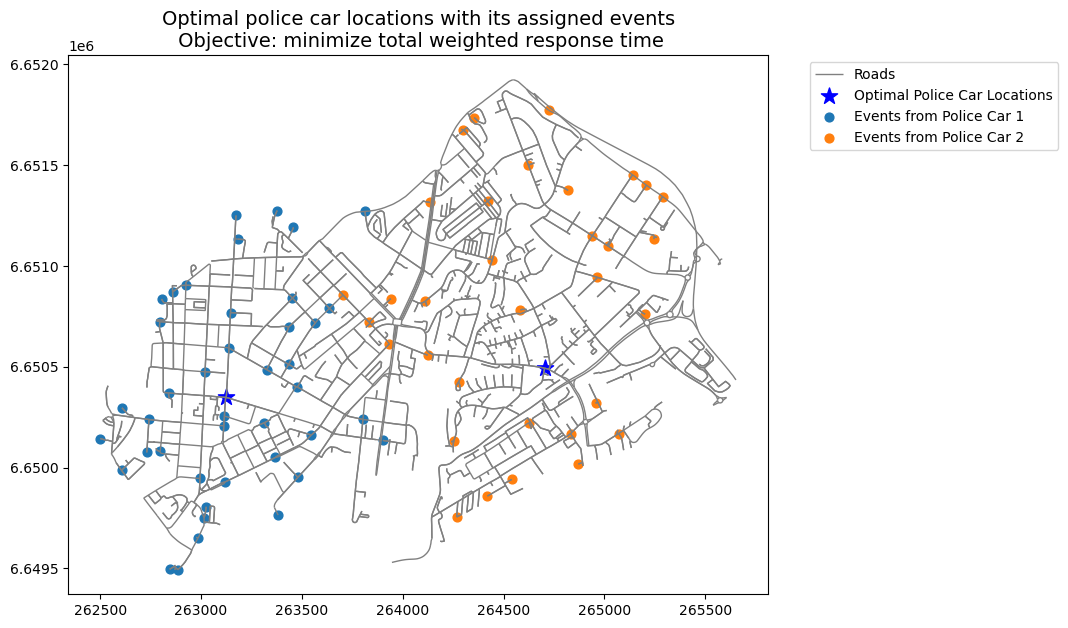

In [154]:
# Plot function
def plot_police_car_events(police_car_locations, events_by_police_car, nodes, edges, title):
    fig, ax = plt.subplots(figsize=(12, 7))
    edges.plot(ax=ax, linewidth=1, edgecolor='gray', label='Roads') # Road network
    police_car_locations.plot(ax=ax, color='blue', marker='*', markersize=150, label='Optimal Police Car Locations') # Optimal police car locations
    for i, police_car in enumerate(police_car_locations.index):
        assigned_events_gdf[assigned_events_gdf.index.isin(events_by_police_car[police_car])].plot(ax=ax, color=f'C{i}', markersize=40, label=f'Events from Police Car {i+1}') # Events from police car i
    ax.set_title(title, fontsize=14)
    plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1)); plt.show()

# Testing plotting function
plot_police_car_events(optimal_police_car_locations_gdf, events_by_police_car, nodes, edges, 'Optimal police car locations with its assigned events\n Objective: minimize total weighted response time')